Just look to see if the sequences overlap

In [1]:
## Load any changes to local modules
%load_ext autoreload
%autoreload 2

import os
import sys

pwd = %pwd

module_path = os.path.abspath(os.path.join('{0}/../../'.format(pwd)))
if module_path not in sys.path:
    sys.path.append(module_path)

study_dir = '{}/{}'.format(module_path, 'results/03072018_proteomics_informatics_tc/')
results_dir = '{}/{}'.format(module_path, 'results/03072018_proteomics_informatics_tc/results')

#results_dir = '{}/{}'.format('/scratch/jonesmic', '03072018_proteomics_informatics_tc/results')



In [96]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import os.path
import numpy as np
%matplotlib inline
from IPython.display import display

pd.set_option('precision', 5)
pd.set_option('max_colwidth', 50)

pd.options.display.float_format = '{:,.2f}'.format



from nbcpact import AnalyzeQuantCompare,Peptide,PeptideGroup,UcbreUtils,PeptidesFromPeptideListBuilder
from dpro.protdisc import PDReaderFactory


In [97]:


class Comparison:
    data_cache = {}
    def __init__(self,
                 comparisonID=None,
                 nibr_input=None, 
                 ucb_input=None, 
                 ucb_output=None, 
                 desc=None, 
                 fdr=0.01):
        self.comparisonID = comparisonID
        self.nibr_input = nibr_input
        self.ucb_input = ucb_input
        self.ucb_output = ucb_output
        self.desc = desc.copy()
        self.Description = desc['Description']
        self.fdr = fdr
        
    def get_nibr_output(self):
        ## Check if the file exists
        file_path = '{}/{}'.format(results_dir, '{}_pd_data.txt'.format(comp.comparisonID))
        if not os.path.isfile(file_path):
            pdReader = self.get_pd_reader()
            df = pdReader.get_target_peptides()
            df.to_csv(file_path, sep='\t', index=False)
        
        df = pd.read_table(file_path)
        return df        
        
    def get_pd_reader(self):
        if not self.nibr_input in self.data_cache.keys():
            if self.nibr_input:
                if os.path.isfile(self.nibr_input):
                    factory = PDReaderFactory()
                    pdReader = factory.createPDReader(self.nibr_input,
                                                      include_non_quant=True,
                                                      fdr=self.fdr,
                                                      validate=True)
                    self.data_cache[self.nibr_input] = pdReader

        if self.nibr_input in self.data_cache.keys():
            return self.data_cache[self.nibr_input]
        else: 
            return None
    
    def get_ucb_input(self):
        if not self.ucb_input in self.data_cache.keys():
            if self.ucb_input:
                if os.path.isfile(self.ucb_input):
                    df = self.load_ip2_peptide_list(self.ucb_input)
                    self.data_cache[self.ucb_input] = df

        return self.data_cache[self.ucb_input]
    
    
    def load_ip2_peptide_list(self, file_path):
        """
            Create a DF with these cols
            ['UNIQUE_1', 'annotation', 'area_ratios', 'decoy',
           'file_AREA_MEDIAN_RATIO_1', 'ip2_peptide', 'mod_locs', 'peptide',
           'ptm_indices', 'run_counter', 'run_data', 'uniprot_ids'],

        """
        peptidesFromPeptideListBuilder = PeptidesFromPeptideListBuilder(file_path)
        df = peptidesFromPeptideListBuilder.generate_peptides_df()

        num_records = df.index.size
        num_seqs = len(set(df['peptide']))

        decoy_df = df[df['annotation'].str.contains('Reverse')]
        num_decoy_records = decoy_df.index.size
        percent_decoy_records = (num_decoy_records/num_records * 100)
        num_decoy_seqs = len(set(decoy_df['peptide']))
        percent_decoy_seqs = (num_decoy_seqs/num_seqs * 100)



        df = df[~df['annotation'].str.contains('Reverse')]
        num_forward_recs = df.index.size
        num_forward_seqs = len(set(df['peptide']))


        msg = 'Records: Tot {}, Forward {} , Decoy {} ({:.0f}%)'.format(num_records, 
                                                                   num_forward_recs, 
                                                                   num_decoy_records, 
                                                                   percent_decoy_records)
        print(msg)

        msg = 'Sequences: Tot {}, Forward {}, Decoy {} ({:.0f}%)'.format(num_seqs, 
                                                                          num_forward_seqs, 
                                                                          num_decoy_seqs, 
                                                                          percent_decoy_seqs)
        print(msg)


        df['RatioRank'] = df["file_AREA_MEDIAN_RATIO_1"].rank(ascending=True)

        ax = sns.regplot(x="RatioRank", y="file_AREA_MEDIAN_RATIO_1", data=df)
        plt.figure()

        intersection = set(df['peptide']) & set(decoy_df['peptide'])
        print('Peptide sequences seen in both the decoy and forward sets {}'.format(intersection))

        cols = ['decoy','file_AREA_MEDIAN_RATIO_1', 'peptide', 'mod_locs']
        return df[cols]
    
    
        
        
def get_comparisons():

    file_path = '{}/{}'.format(study_dir, 'comparisons.txt')
    df = pd.read_table(file_path)

    comparisons = df.apply(lambda x : Comparison(comparisonID=x['Comparison'], 
                                                 nibr_input=x['NIBR_INPUT'], 
                                                 ucb_input=x['UCB_INPUT'], 
                                                 ucb_output=x['UCB_OUTPUT'], 
                                                 desc=x, 
                                                 fdr=x['FDR']), 
                           axis=1)


    #for comp in comparisons:
    #    display(comp.desc)
    return comparisons

    print('DONE')
    
comparisons = get_comparisons()

In [98]:
def clean_df(df):
    print('Cleaning up DF')
    cols = set(df.columns.values)

    # cols.remove('FEATURE')
    first_cols = ['IN_BOTH', 'Modifications_best_positions', 'QvalityPEP']
    cols = list(cols - set(first_cols))
    cols.sort()
    
    for col in first_cols:
        cols.insert(0, cols)
    
    #df.columns = map(str.upper, df.columns)
    df = df[cols]
    return df


In [110]:

def do_sequence_overlap_bymerge(ip2DF=None,  pdDF=None, comp=None):
    ip2DF = ip2DF.copy()
    pdDF = pdDF.copy()

    ip2DF['peptide_ip2'] = ip2DF['peptide']
    pdDF['peptide_pd'] = pdDF['Sequence']
    
    df = pd.merge(ip2DF, pdDF, left_on='peptide_ip2', right_on='peptide_pd', suffixes=['_ip2', '_pd'], how='outer')
    df['IN_BOTH'] = (df['peptide_ip2'] == df['peptide_pd'])
    
    data = {}

    ip2_peps = set(df['peptide_ip2'])
    pd_peps = set(df['peptide_pd'])
        
    pd_peps_with_ratios = set(df[~df.ABUNDANCE_RATIOS.isnull()].Sequence)

    intersection = ip2_peps & pd_peps
    percent_ip2_covered = len(intersection)/len(ip2_peps)*100

    data['IP2 Peps'] = len(ip2_peps) 
    data['PD Peps'] = len(pd_peps)
    data['Common Peps'] = len(intersection)
    data['% IP2 Covered in PD'] = percent_ip2_covered

    intersection_with_ratios = ip2_peps & pd_peps_with_ratios
    percent_ip2_covered = len(intersection_with_ratios)/len(ip2_peps)*100
    overlapping_pd_peps_missing_ratios = intersection - intersection_with_ratios 

    
    
    data['Quant PD Peps'] = len(pd_peps_with_ratios)
    data['Quant Common Peps'] = len(intersection_with_ratios)
    data['% IP2 Covered with PD Quant Peps'] = percent_ip2_covered

    do_ratio_plot(df, comp=comp, groupby_col='peptide_ip2')
    return (df, pd.Series(data))

def do_probe_overlap_bymerge(ip2DF=None,  pdDF=None, comp=None):
    ip2DF = ip2DF.copy()
    pdDF = pdDF.copy()
    
    # Remove non-probed peptides
    
    #pdDF = pdDF[pdDF['PROBE_MOD_LOCS'].apply(lambda x : len(x) > 0)]
    
    pdDF['PROBE_MOD_LOCS'] = pdDF['PROBE_MOD_LOCS'].apply(lambda x : re.sub(r"[\[\]'\s]", '', x).split(','))
    
    
    ip2DF['probe_peptide_ip2'] = ip2DF['peptide'] + '_C' + ip2DF.mod_locs.apply(lambda x : ',C'.join(map(str, x)))
    pdDF['probe_peptide_pd'] = pdDF['Sequence'] + '_' + pdDF.PROBE_MOD_LOCS.apply(lambda x : ','.join(x))

    df = pd.merge(ip2DF, pdDF, left_on='probe_peptide_ip2', right_on='probe_peptide_pd', suffixes=['_ip2', '_pd'], how='outer')
    df['IN_BOTH'] = (df['probe_peptide_ip2'] == df['probe_peptide_pd'])

    data = {}
    
    ip2_peps = set(df['probe_peptide_ip2'])
    pd_peps = set(df['probe_peptide_pd'])
    intersection = ip2_peps & pd_peps
    percent_ip2_covered = len(intersection)/len(ip2_peps)*100

    
    data['Probed IP2 Peps'] = len(ip2_peps) 
    data['Probed PD Peps'] = len(pd_peps)
    data['Probed Common Peps'] = len(intersection)
    data['% IP2 Covered in Probed PD'] = percent_ip2_covered

    
    pd_peps_with_ratios = set(df[~df['ABUNDANCE_RATIOS'].isnull()]['probe_peptide_pd'])
    intersection_with_ratios = ip2_peps & pd_peps_with_ratios
    percent_ip2_covered = len(intersection_with_ratios)/len(ip2_peps)*100

    
    overlapping_pd_peps_missing_ratios = intersection - intersection_with_ratios 
    
    data['Quant PD Probed Peps'] = len(pd_peps_with_ratios)
    data['Quant Common Probed Peps'] = len(intersection_with_ratios)
    data['% IP2 Covered with PD Quant Probed Peps'] = percent_ip2_covered
    
    do_ratio_plot(df, comp)

    return (df, pd.Series(data))
     
 
def do_ratio_plot(df, comp=None, groupby_col='probe_peptide_ip2'):

    ip2_ratio_col = 'file_AREA_MEDIAN_RATIO_1'
    pd_ratio_col = 'ABUNDANCE_RATIOS'

    df = df[df['IN_BOTH']] 
    groups = df.groupby(groupby_col)
    
    ip2_ratios = groups[ip2_ratio_col].median()
    pd_ratios = groups[pd_ratio_col].median()

    df = pd.DataFrame(dict(MED_IP2_R = ip2_ratios, MED_PD_R = pd_ratios)).reset_index()
    
    # This has an R of 2.683 in PD. And here too
    display(df[df[groupby_col].str.contains('LVAFCPFASSQVALENANAVSEGVVHEDLR')]) 
    
    display(df[df['MED_IP2_R']>50]) 
    
    g = sns.jointplot(x='MED_IP2_R', y= 'MED_PD_R', data=df, kind="reg",
                      color="r", size=7)
    
    g.fig.suptitle('{}:{} [{}]'.format(groupby_col, comp.comparisonID, comp.Description))
    
    plt.figure()
    

Comp2


,peptide_ip2,MED_IP2_R,MED_PD_R
1657,LVAFCPFASSQVALENANAVSEGVVHEDLR,3.82,2.68


,peptide_ip2,MED_IP2_R,MED_PD_R
22,AAQDFFSTCR,250.73,nan
564,DPSKNDTCK,"1,000.00",0.01
634,EGCEAIVDTGTSLMVGPVDEVR,501.22,0.38
682,ELSFSGIPCEGGLR,53.19,0.01
1077,HVVCAAETGSGK,51.07,nan
1246,ISGLPVCPELVR,"1,000.00",nan
1477,LGCQDAFPEVYDK,500.20,nan
1635,LSSPVPAVCR,228.47,1.89
2197,SSSSSSASAAAAAAAASSSASCSR,257.24,0.01
2428,TVVNISSLCALQPFK,256.08,0.01


,probe_peptide_ip2,MED_IP2_R,MED_PD_R
1593,LVAFCPFASSQVALENANAVSEGVVHEDLR_C5,3.82,2.68


,probe_peptide_ip2,MED_IP2_R,MED_PD_R
21,AAQDFFSTCR_C9,250.73,nan
545,DPSKNDTCK_C8,"1,000.00",0.01
612,EGCEAIVDTGTSLMVGPVDEVR_C3,501.22,0.38
659,ELSFSGIPCEGGLR_C9,53.19,0.01
1035,HVVCAAETGSGK_C4,51.07,nan
1198,ISGLPVCPELVR_C7,"1,000.00",nan
1422,LGCQDAFPEVYDK_C3,500.20,nan
1571,LSSPVPAVCR_C9,228.47,1.89
1662,"MTEEPLMCAYCVTEPGAGSDVAGIK_C8,C11",254.45,nan
2109,SSSSSSASAAAAAAAASSSASCSR_C22,257.24,0.01


Comp3


,peptide_ip2,MED_IP2_R,MED_PD_R
1657,LVAFCPFASSQVALENANAVSEGVVHEDLR,3.82,2.68


,peptide_ip2,MED_IP2_R,MED_PD_R
22,AAQDFFSTCR,250.73,nan
564,DPSKNDTCK,"1,000.00",0.01
634,EGCEAIVDTGTSLMVGPVDEVR,501.22,0.38
682,ELSFSGIPCEGGLR,53.19,0.01
1077,HVVCAAETGSGK,51.07,nan
1246,ISGLPVCPELVR,"1,000.00",nan
1477,LGCQDAFPEVYDK,500.20,nan
1635,LSSPVPAVCR,228.47,1.89
2197,SSSSSSASAAAAAAAASSSASCSR,257.24,0.01
2428,TVVNISSLCALQPFK,256.08,0.01


,probe_peptide_ip2,MED_IP2_R,MED_PD_R
1593,LVAFCPFASSQVALENANAVSEGVVHEDLR_C5,3.82,2.68


,probe_peptide_ip2,MED_IP2_R,MED_PD_R
21,AAQDFFSTCR_C9,250.73,nan
545,DPSKNDTCK_C8,"1,000.00",0.01
612,EGCEAIVDTGTSLMVGPVDEVR_C3,501.22,0.38
659,ELSFSGIPCEGGLR_C9,53.19,0.01
1035,HVVCAAETGSGK_C4,51.07,nan
1198,ISGLPVCPELVR_C7,"1,000.00",nan
1422,LGCQDAFPEVYDK_C3,500.20,nan
1571,LSSPVPAVCR_C9,228.47,1.89
1662,"MTEEPLMCAYCVTEPGAGSDVAGIK_C8,C11",254.45,nan
2109,SSSSSSASAAAAAAAASSSASCSR_C22,257.24,0.01


Comp5


,peptide_ip2,MED_IP2_R,MED_PD_R
1656,LVAFCPFASSQVALENANAVSEGVVHEDLR,3.82,2.68


,peptide_ip2,MED_IP2_R,MED_PD_R
23,AAQDFFSTCR,250.73,nan
564,DPSKNDTCK,"1,000.00",0.01
635,EGCEAIVDTGTSLMVGPVDEVR,501.22,0.38
683,ELSFSGIPCEGGLR,53.19,0.01
1076,HVVCAAETGSGK,51.07,nan
1246,ISGLPVCPELVR,"1,000.00",nan
1477,LGCQDAFPEVYDK,500.20,nan
1634,LSSPVPAVCR,228.47,1.89
2200,SSSSSSASAAAAAAAASSSASCSR,257.24,0.01
2431,TVVNISSLCALQPFK,256.08,0.01


,probe_peptide_ip2,MED_IP2_R,MED_PD_R
1588,LVAFCPFASSQVALENANAVSEGVVHEDLR_C5,3.82,2.68


,probe_peptide_ip2,MED_IP2_R,MED_PD_R
22,AAQDFFSTCR_C9,250.73,nan
545,DPSKNDTCK_C8,"1,000.00",0.01
613,EGCEAIVDTGTSLMVGPVDEVR_C3,501.22,0.38
660,ELSFSGIPCEGGLR_C9,53.19,0.01
1034,HVVCAAETGSGK_C4,51.07,nan
1196,ISGLPVCPELVR_C7,"1,000.00",nan
1418,LGCQDAFPEVYDK_C3,500.20,nan
1566,LSSPVPAVCR_C9,228.47,1.89
1659,"MTEEPLMCAYCVTEPGAGSDVAGIK_C8,C11",254.45,nan
2108,SSSSSSASAAAAAAAASSSASCSR_C22,257.24,0.01


Done doing comparisons


,Comparison,NIBR_INPUT,UCB_INPUT,UCB_OUTPUT,UCB Enz,NIBR Enz,FDR,UCB Max Internal Cleavages,NIBR Max Internal Cleavages2,UCB Diff Mods / Peptide*,...,PD Peps,Quant Common Peps,Quant PD Peps,% IP2 Covered in Probed PD,% IP2 Covered with PD Quant Probed Peps,Probed Common Peps,Probed IP2 Peps,Probed PD Peps,Quant Common Probed Peps,Quant PD Probed Peps
0,Comp2,/da/dmp/cb/jonesmic/chemgx/dpro_studies/2018/N...,/home/jonesmic/gBuild/jonesmic_github/proteomi...,/home/jonesmic/gBuild/jonesmic_github/proteomi...,Full Tryptic,Full Tryptic,0.01,1,1,2,...,"17,272.00","2,176.00","2,746.00",65.14,51.92,"2,700.00","4,145.00","17,867.00","2,152.00","2,760.00"
1,Comp3,/da/dmp/cb/jonesmic/chemgx/dpro_studies/2018/N...,/home/jonesmic/gBuild/jonesmic_github/proteomi...,/home/jonesmic/gBuild/jonesmic_github/proteomi...,Full Tryptic,Full Tryptic,NaN,1,1,2,...,"17,272.00","2,176.00","2,746.00",65.14,51.92,"2,700.00","4,145.00","17,867.00","2,152.00","2,760.00"
2,Comp5,/da/dmp/cb/jonesmic/chemgx/dpro_studies/2018/N...,/home/jonesmic/gBuild/jonesmic_github/proteomi...,/home/jonesmic/gBuild/jonesmic_github/proteomi...,Full Tryptic,Full Tryptic,0.01,1,2,3,...,"17,685.00","2,173.00","2,755.00",65.09,51.75,"2,698.00","4,145.00","18,284.00","2,145.00","2,770.00"


Done


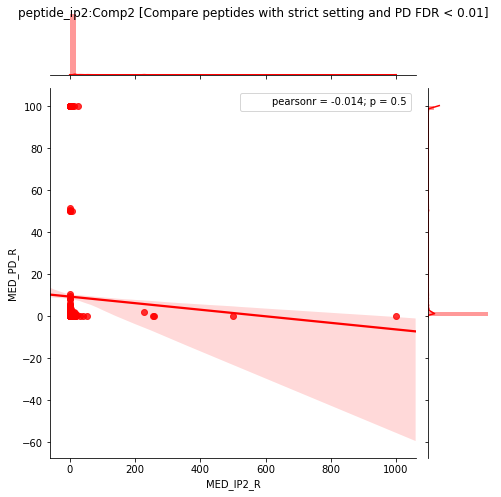

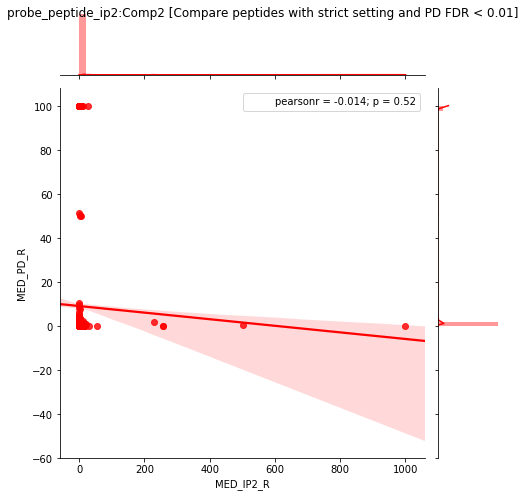

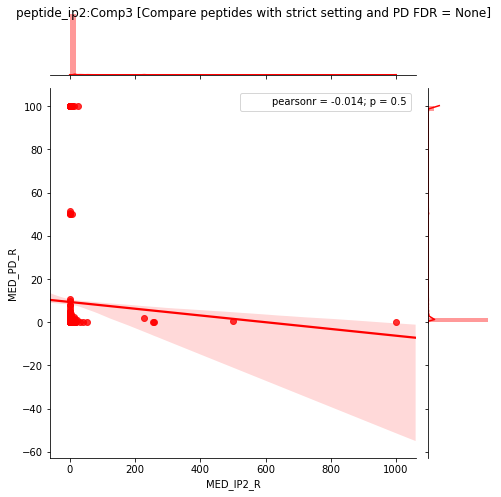

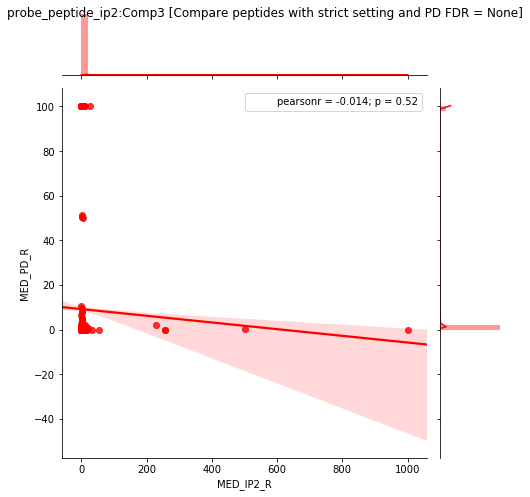

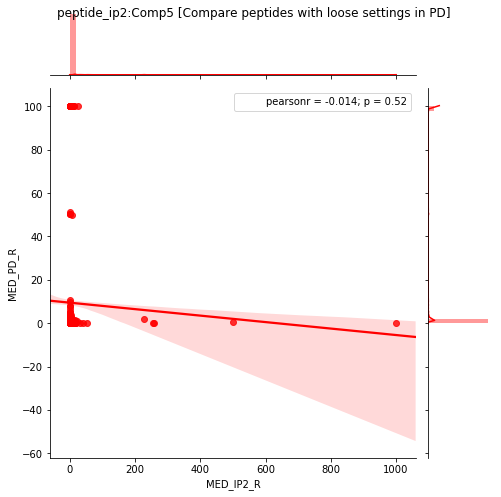

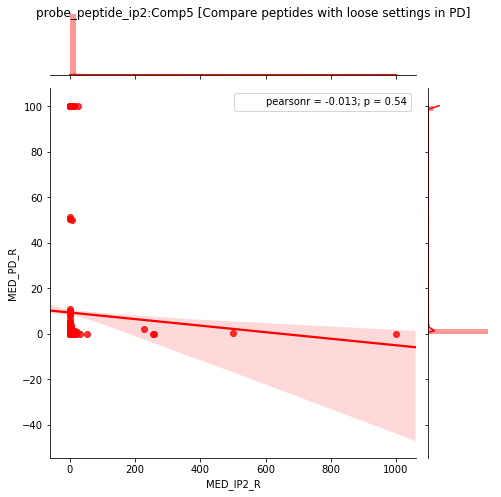

In [111]:
results = {}
for comp in comparisons:
    if comp.get_pd_reader():
        print(comp.comparisonID)
        pdDF = comp.get_nibr_output()

        ip2DF = comp.get_ucb_input()
        
        parts = [comp.desc]
        
        result = do_sequence_overlap_bymerge(ip2DF=ip2DF, pdDF=pdDF, comp=comp)
        parts.append(result[1])
        
        file_path = '{}/{}'.format(results_dir, '{}_pep_overlap.txt'.format(comp.comparisonID))

        result[0].to_csv(file_path, sep='\t', index=False)
        
        result = do_probe_overlap_bymerge(ip2DF=ip2DF, pdDF=pdDF, comp=comp)
        parts.append(result[1])
        
        
        file_path = '{}/{}'.format(results_dir, '{}_pep_probe_overlap.txt'.format(comp.comparisonID))
        result[0].to_csv(file_path, sep='\t', index=False)

        results[comp.comparisonID] = parts

        """super_dict = {}
        for d in parts:
            for k, v in d.iteritems():  # d.items() in Python 3+
                super_dict[k] = v
                
        results.append(pd.Series(data=super_dict))"""    
    else:
        pass
        #print('Missing PD data for {}'.format(comp.desc))
        
print('Done doing comparisons')
#results = pd.concat(results, axis=1).T

#df = results
#df = clean_df(df)

#file_path = '{}/{}'.format(results_dir, 'peptide_compare.txt')

#df.to_csv(file_path, sep='\t', index=False)
#print('Writing files')

parts = []
for comp in results.keys():
    parts.append(pd.concat(results[comp]))

df = pd.concat(parts, axis=1).T

display(df)
file_path = '{}/{}'.format(results_dir, 'peptide_compare.txt')

df.to_csv(file_path, sep='\t', index=False)
print('Done')

,sequence,PTM_INDEX,P-VALUE,Q-VALUE,UNIQUE_1,AREA_RATIO_ALL_1,AREA_MEDIAN_RATIO_1,AREA_RATIO_STDEV_1,AREA_RATIO_COUNT_1,LR_RATIO_1,...,PEPTIDE_PVALUE_1,XCORR_1,DEL_CN_1,LIGHT_AREA_1,HEAVY_AREA_1,PROFILE_SCORE_1,SCAN_1,ENRICHMENT_1,protein,SEQUENCE
2454,AAQDFFSTC(464.28596)R,X ;C53 C59 ;C53 C59 ;,0.50,1.00,"X;,;,;","X;1000.0,;0.79963,;",500.40,154.88,2,"X;0.0,;0.24845,;",...,"X;1.0,;0.2655021023786259,;","X;2.1126,;3.2073,;","X;0.0,;0.01366,;","X;621054.0,;2.6110862E7,;","X;0.0,;3.2653568E7,;","X;0.96951,;0.26568,;","X;13328,;14784,;","X;0.0,;0.0,;",X:;H0Y5R6 Uroporphyrinogen decarboxylase (Frag...,AAQDFFSTCR
2463,AAQDFFSTC(470.29977)R,X ;C53 C59 ;C53 C59 ;,0.15,0.43,"X;,;,;","X;1.31054,;0.79963,;",1.06,1.42,2,"X;0.91286,;0.24845,;",...,"X;0.022125640056303575,;0.2655021023786259,;","X;2.7994,;3.3938,;","X;0.22779,;0.01366,;","X;5269140.0,;2.6110862E7,;","X;4020580.0,;3.2653568E7,;","X;0.68033,;0.26568,;","X;13440,;14788,;","X;0.0,;0.0,;",X:;H0Y5R6 Uroporphyrinogen decarboxylase (Frag...,AAQDFFSTCR


501.22000000000003

In [136]:
## Compare older (SemiTryptic) with new
new_df = pd.read_csv('/home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/datanocommit/03072018_proteomics_informatics_tc/KEA_EN80_UCB_RERUN/peptideList.csv')
new_df['SEQUENCE'] = new_df.sequence.str.replace('[()\d.]+','')
display(new_df[new_df['SEQUENCE'] == 'AAQDFFSTCR'])
old_df = pd.read_csv('/home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/datanocommit/KEA_EN80_12132017/peptideList.csv')
old_df['SEQUENCE'] = old_df.sequence.str.replace('[()\d.]+','')

,sequence,PTM_INDEX,P-VALUE,Q-VALUE,UNIQUE_1,AREA_RATIO_ALL_1,AREA_MEDIAN_RATIO_1,AREA_RATIO_STDEV_1,AREA_RATIO_COUNT_1,LR_RATIO_1,...,PEPTIDE_PVALUE_1,XCORR_1,DEL_CN_1,LIGHT_AREA_1,HEAVY_AREA_1,PROFILE_SCORE_1,SCAN_1,ENRICHMENT_1,protein,SEQUENCE
2454,AAQDFFSTC(464.28596)R,X ;C53 C59 ;C53 C59 ;,0.50,1.00,"X;,;,;","X;1000.0,;0.79963,;",500.40,154.88,2,"X;0.0,;0.24845,;",...,"X;1.0,;0.2655021023786259,;","X;2.1126,;3.2073,;","X;0.0,;0.01366,;","X;621054.0,;2.6110862E7,;","X;0.0,;3.2653568E7,;","X;0.96951,;0.26568,;","X;13328,;14784,;","X;0.0,;0.0,;",X:;H0Y5R6 Uroporphyrinogen decarboxylase (Frag...,AAQDFFSTCR
2463,AAQDFFSTC(470.29977)R,X ;C53 C59 ;C53 C59 ;,0.15,0.43,"X;,;,;","X;1.31054,;0.79963,;",1.06,1.42,2,"X;0.91286,;0.24845,;",...,"X;0.022125640056303575,;0.2655021023786259,;","X;2.7994,;3.3938,;","X;0.22779,;0.01366,;","X;5269140.0,;2.6110862E7,;","X;4020580.0,;3.2653568E7,;","X;0.68033,;0.26568,;","X;13440,;14788,;","X;0.0,;0.0,;",X:;H0Y5R6 Uroporphyrinogen decarboxylase (Frag...,AAQDFFSTCR


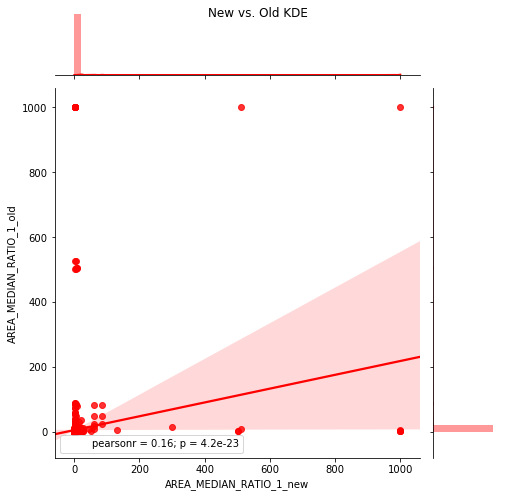

In [139]:
mergeDF = pd.merge(new_df, old_df, on='sequence', suffixes=['_new', '_old'])
mergeDF = mergeDF[~(mergeDF['AREA_MEDIAN_RATIO_1_new'].isnull() | mergeDF['AREA_MEDIAN_RATIO_1_old'].isnull())]

g = sns.jointplot(x='AREA_MEDIAN_RATIO_1_new', y= 'AREA_MEDIAN_RATIO_1_old', data=mergeDF, kind="reg",
                  color="r", size=7)

g.fig.suptitle('New vs. Old KDE')